## Female-Headed Households in South Africa(ZINDI)

The objective is to build a predictive model that accurately estimates the % of households per ward that are female-headed and living below a particular income threshold by using data points that can be collected through other means without an intensive household survey like the census.

This solution can potentially reduce the cost and improve the accuracy of monitoring key population indicators such as female household headship and income level in between census years. 

South Africa is divided into over 4,000 wards. We have aggregated the target indicator and the other predictive variables from the 2011 census across all the households within each ward to create an aggregated value of each indicator per ward.

The target variable of interest is the percentage of households per ward that are both female-headed and earn an annual income that is below R19,600 (approximately $2,300 USD in 2011). For context, the poverty line in South Africa is defined as R1,183 per month per person and the average individual salary in South Africa is R20,860 per month.

The objective of this challenge is to accurately model the target indicator using the predictive variables provided in the datasets. For the purposes of this competition, we have split the wards into a train and test set. You will train your model on the 2,822 wards in the train set and apply your model to the 1,013 wards in the test set.

##### Data

Train.csv - is the dataset that can be used to train the model.

Test.csv - is the dataset on which can be applied the model to. This dataset contains the same variables as the test data except there is no target. This is what need to predict.

VariableDefinitions.csv - is the full list of variables and their explanations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

Let's look at the train dataset and variable_descriptions.csv.

In [9]:
df = pd.read_csv('Train.csv')
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [10]:
df_dv = pd.read_csv('variable_descriptions.csv')
df_dv.head()

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or bric...,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional d...,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apart...,NaN,NaN
3,dw_03,Percentage of dwellings of type: Cluster house...,NaN,NaN
4,dw_04,Percentage of dwellings of type: Townhouse (se...,NaN,NaN


### EDA

For better understanding of data neccesary to visualize the behavior of some features. First of all lets look at the distribution of target value

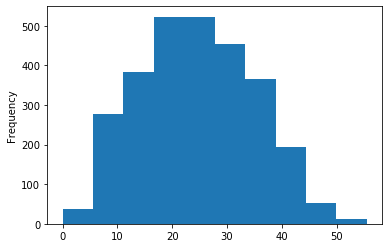

In [31]:
# Plot the distribution

ax = df['target'].plot(kind='hist')

Correlation information

In [32]:
# looking at the positive correlation 

df.corr()['target'].sort_values(ascending=False).head(10)

target    1.000000
psa_00    0.782472
pg_00     0.613346
pw_06     0.470676
dist_c    0.463774
dw_01     0.458206
pw_02     0.442441
pw_03     0.440941
pw_04     0.389467
pw_05     0.349653
Name: target, dtype: float64

In [33]:
# And negative correlations

df.corr()['target'].sort_values().head(10)

pw_00              -0.754536
car_00             -0.702831
stv_00             -0.664181
lln_00             -0.637835
pg_03              -0.583908
NL                 -0.514398
lan_00             -0.507942
lan_01             -0.438704
dw_03_04           -0.390951
total_households   -0.374833
Name: target, dtype: float64

Visualize some of them 

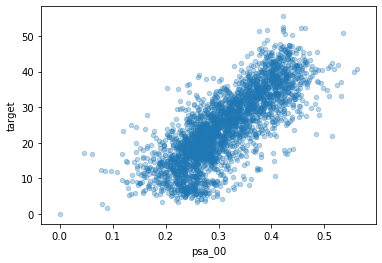

In [34]:
#psa_00 Percentage listing present school attendance

df.plot(x='psa_00', y='target', kind='scatter', alpha=0.3)

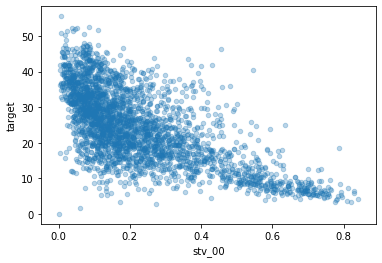

In [35]:
## stv_00 Percentage of households with Satellite TV
df.plot(x='stv_00', y='target', kind='scatter', alpha=0.3)

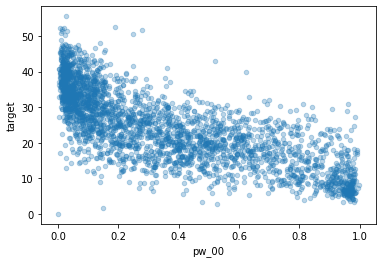

In [36]:
##pw_00 Percentage with piped water access

df.plot(x='pw_00', y='target', kind='scatter', alpha=0.3)

### Feature engineering

For making model most effective dataset should be cleaned and optimized. 
Check the dataset on NULL value

In [16]:
#finding columns with Null values

df2 = df.loc[:, (df != 0).any(axis=0)]
diff_cols = df.columns.difference(df2.columns)
diff_cols

Index(['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08'], dtype='object')

It was found 5 columns with null values. Delete them!

In [17]:
#deleting columns with Null values

out_col = ['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08']
df = df.drop(out_col, 1)

Look carefully on descriptions of columns. Some of them devided on Yes/No columns. Such as Percentage of households with Satellite TV, Percentage of households with a car and so on. It's an excess information here. So deleting No-columns makes datafarme more compact without loosing data.

In [18]:
df_dv

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or bric...,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional d...,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apart...,NaN,NaN
3,dw_03,Percentage of dwellings of type: Cluster house...,NaN,NaN
4,dw_04,Percentage of dwellings of type: Townhouse (se...,NaN,NaN
5,dw_05,Percentage of dwellings of type: Semi-detached...,NaN,NaN
6,dw_06,Percentage of dwellings of type: House/flat/ro...,NaN,NaN
7,dw_07,Percentage of dwellings of type: Informal dwel...,in backyard),NaN
8,dw_08,Percentage of dwellings of type: Informal dwel...,not in backyard,e.g. in an informal/squatter settlement or on...
9,dw_09,Percentage of dwellings of type: Room/flatlet ...,NaN,NaN


In [19]:
#drop 'No' columnes.

no_columns = ["psa_01", "stv_01", "car_01", "lln_01"]
df = df.drop(no_columns, axis = 1)

Also adding Household_Size column(average number of individuals in household) can give addition information about households

In [20]:
#average number of individuals in household

df['Household_Size'] = df['total_individuals']/df['total_households']

It will be easier to operate with numeric columns here

In [21]:
#changing type of 'ward' column to numeric

df['ward_num'] = df['ward'].apply(lambda x: x.split(":")[0])
df['ward_num'] = pd.to_numeric(df["ward_num"])

Unnecessary column about domestic codes

In [24]:
df = df.drop('ADM4_PCODE', axis=1)

Assuming that the distance between the ward and town/city can influene on the incomes in wards, extraxt information about coordinates of all cities and towns of South Africa. Use function get_dist to count distance to closest city/town and put then into dist_c, dist_t columns of train dataset. 

In [22]:
#adding data about coordinates of cities and towns of South Africa

towns = pd.read_excel("towns.xls", index_col=None, header=None)
cities = pd.read_excel("cities.xls", index_col=None, header=None)

In [23]:
## function getting the shortest distance between the ward and all cities and towns of South Africa

def get_dist(value, cities, towns):#
    dist_c = np.sqrt((cities[1]-value[0])**2 + (cities[2]-value[1])**2)
    dist_t = np.sqrt((towns[1]-value[0])**2 + (towns[2]-value[1])**2)
    mindist_c = dist_c.min() 
    mindist_t = dist_t.min()
    return mindist_c, mindist_t

In [25]:
#adding columns with distances to cities and towns 

df[['dist_c','dist_t']] = pd.DataFrame(df[["lat", "lon"]].apply(lambda x: get_dist(x, cities, towns), axis=1).tolist(), index=df.index)

Please look at the plot below. Seems that features dw_3 and dw_4 has similar behavior. In this way it's possible to join them by maximazing values.

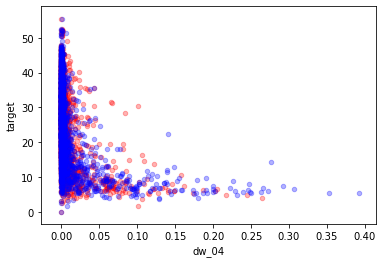

In [26]:
#dw_03 and dw_04 has similar bihavior

ax1 = df.plot(x='dw_03', y='target', kind='scatter', alpha=0.3, color='r')
ax2 = df.plot(x='dw_04', y='target', kind='scatter', alpha=0.3, color='b', ax=ax1)

In [27]:
# join 2 feature into one, maximazing them

df['dw_03_04'] = df[["dw_03", "dw_04"]].max(axis=1)
df = df.drop("dw_03", axis=1)
df = df.drop("dw_04", axis=1)

To add the most diverse target values to the training dataset, split in accordance with target diapasons

In [26]:
#split target column on 11 ranges

def get_diap(X):
    if X < 5:
        return 1
    elif X < 10 and X > 5:
        return 2
    elif X < 15 and X > 10:
        return 3
    elif X < 20 and X > 15:
        return 4 
    elif X < 25 and X > 20:
        return 5
    elif X < 30 and X > 25:
        return 6
    elif X < 35 and X > 30:
        return 7
    elif X < 40 and X > 35:
        return 8
    elif X < 45 and X > 40:
        return 9
    elif X < 50 and X > 45:
        return 10 
    elif X < 56 and X > 50:
        return 11 

In [27]:
#adding column with target diapasons to split data evenly

df["target_diap"] = df["target"].apply(lambda X: get_diap(X))
X = df[df.columns.difference(['ward', 'target', 'target_diap'])]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=750, stratify = df["target_diap"])

Ensamble method has been chosen for the training model. 

In [28]:
reg1 = GradientBoostingRegressor(n_estimators=600)
reg2 = linear_model.BayesianRidge(n_iter=2)
reg3 = xgb.XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=100, objective='reg:squarederror', subsample=0.55, min_child_weight=9)
vot = VotingRegressor(estimators=[('gb', reg1), ('br', reg2), ('xb', reg3)])
vot = vot.fit(X_train, y_train)